In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import normalized_mutual_info_score, pairwise_distances
from sklearn.cluster import KMeans as KMeansSk

from models import *
from coreset import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'models'

In [1]:
data = pd.read_csv('data/bio_train.csv', header=None)

X = data.loc[:, 1:]
true_labels = data.loc[:, 0]

scaler = StandardScaler()
X = scaler.fit_transform(X)

NameError: name 'pd' is not defined

# Lloyd’s algorithm for k-Means Clustering 

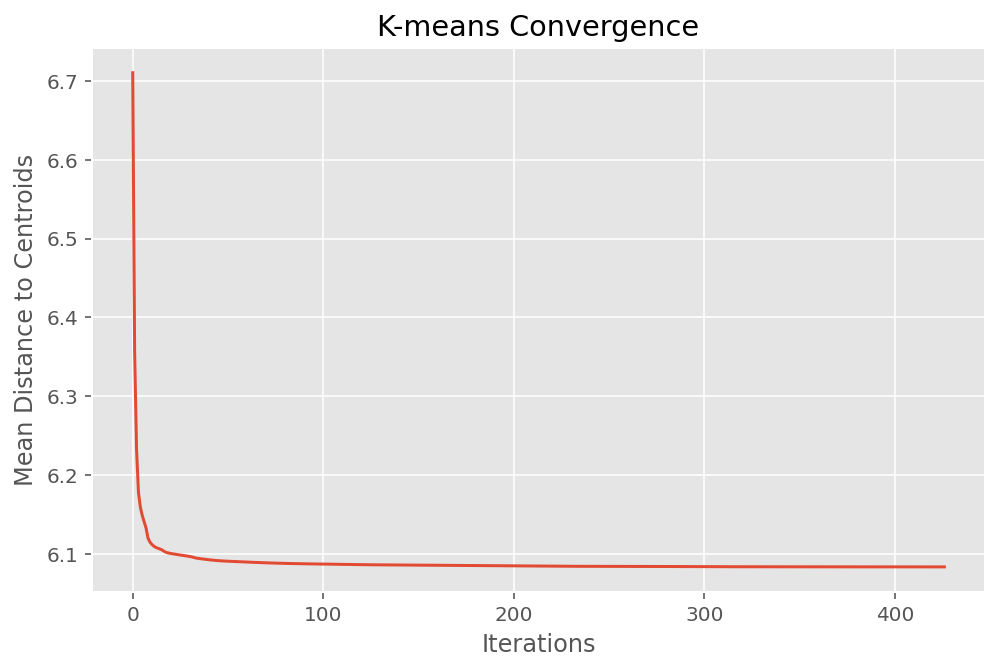

NMI: 0.1943359404636225
Runtime: 207.67386507987976 sec
Distance Computations: 9521993250
Iterations: 427


In [75]:
kmeans = KMeans(k=153)
start_time = time.time()
labels = kmeans.fit_predict(X)
end_time = time.time()

nmi = normalized_mutual_info_score(true_labels, labels)
runtime = end_time - start_time
distance_computations = kmeans.distance_computations
iterations = kmeans.iterations

plt.plot(kmeans.convergence_history)

plt.xlabel('Iterations')
plt.ylabel('Mean Distance to Centroids')
plt.title('K-means Convergence')
plt.show()

print(f'NMI: {nmi}')
print(f'Runtime: {runtime} sec')
print(f'Distance Computations: {distance_computations}')
print(f'Iterations: {iterations}')

# k-Means with Locality Sensitive Hashing (LSH)

In [11]:
class LSH:

    def __init__(self, num_hashes, hash_size, input_dim):
        self.num_hashes = num_hashes
        self.hash_size = hash_size
        self.input_dim = input_dim
        self.planes = [np.random.randn(input_dim, hash_size) for _ in range(num_hashes)]
    
    def hash(self, X):
        hash_values = np.array([self._hash_single(X, plane) for plane in self.planes])
        return hash_values
    
    def _hash_single(self, X, plane):
        projections = np.dot(X, plane)
        return (projections > 0).astype(int)
    
    def combine_hashes(self, hash_values, method='AND'):
        if method == 'AND':
            combined = np.all(hash_values, axis=0).astype(int)
        elif method == 'OR':
            combined = np.any(hash_values, axis=0).astype(int)
        return combined

    def combined_hash(self, X, method='AND'):
        hash_values = self.hash(X)
        return self.combine_hashes(hash_values, method)
    

class KMeansLSH(KMeans):

    def __init__(self, k, num_hashes=4, hash_size=4, combination_method='AND'):
        super().__init__(k)
        self.num_hashes = num_hashes
        self.hash_size = hash_size
        self.combination_method = combination_method
        self.lsh = None
    
    def fit(self, X):
        self.centers = X[:self.k]
        self.labels = np.zeros(X.shape[0], dtype=int)
        self.convergence_history = []
        self.iterations = 0
        self.lsh = LSH(self.num_hashes, self.hash_size, X.shape[1])

        self.point_hashes = self.lsh.combined_hash(X, method=self.combination_method)
        
        while True:
            prev_labels = self.labels.copy()
            self.labels = self._assign_clusters(X).astype(int)
            self.centers = self._compute_centers(X)

            if np.all(prev_labels == self.labels):
                break

            self.convergence_history.append(np.mean(np.linalg.norm(X - self.centers[self.labels], axis=1)))
            self.iterations += 1

        self.distance_computations = self.iterations * X.shape[0] * self.k
    
    def _assign_clusters(self, X):
        center_hashes = self.lsh.combined_hash(self.centers, method=self.combination_method)
        hash_buckets = defaultdict(list)

        for idx, point_hash in enumerate(self.point_hashes.T):
            bucket_key = tuple(point_hash)
            hash_buckets[bucket_key].append(idx)

        labels = np.zeros(X.shape[0], dtype=int)
        for center_idx, center_hash in enumerate(center_hashes.T):
            bucket_key = tuple(center_hash)
            if bucket_key in hash_buckets:
                for point_idx in hash_buckets[bucket_key]:
                    labels[point_idx] = center_idx
        
        remaining_points = np.setdiff1d(np.arange(X.shape[0]), np.array([idx for indices in hash_buckets.values() for idx in indices]))
        distances = self._calculate_distances(X[remaining_points], self.centers)
        labels[remaining_points] = np.argmin(distances, axis=1)
        
        return labels

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [11:37<00:00, 139.47s/it]


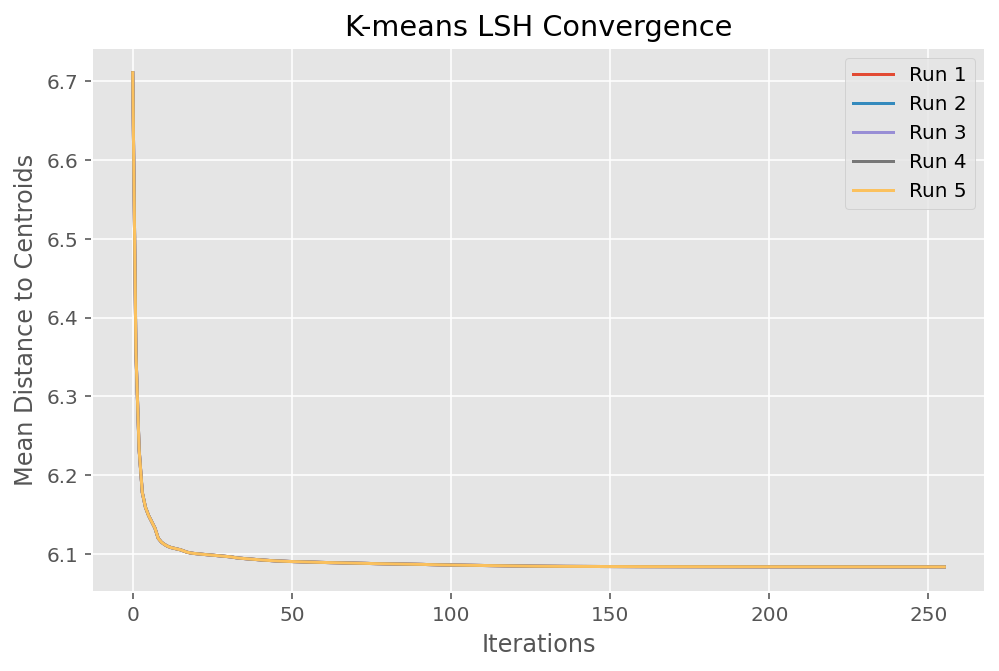

Average NMI: 0.19409483995921542
Average Runtime: 139.4144003868103 sec
Average Distance Computations: 5708736000.0
Average Iterations: 256.0


In [12]:
def run_kmeans_lsh(data, true_labels, k=153, num_hashes=4, hash_size=4, combination_method='AND', n_runs=5):
    nmi_scores = []
    runtimes = []
    distance_computations = []
    iterations = []

    for _ in tqdm(range(n_runs)):
        kmeans = KMeansLSH(k=k, num_hashes=num_hashes, hash_size=hash_size, combination_method=combination_method)
        start_time = time.time()
        labels = kmeans.fit_predict(data)
        end_time = time.time()

        nmi = normalized_mutual_info_score(true_labels, labels)
        nmi_scores.append(nmi)
        runtimes.append(end_time - start_time)
        distance_computations.append(kmeans.distance_computations)
        iterations.append(kmeans.iterations)

        plt.plot(kmeans.convergence_history, label=f'Run {_+1}')

    plt.xlabel('Iterations')
    plt.ylabel('Mean Distance to Centroids')
    plt.title('K-means LSH Convergence')
    plt.legend()
    plt.show()

    avg_nmi = np.mean(nmi_scores)
    avg_runtime = np.mean(runtimes)
    avg_distance_computations = np.mean(distance_computations)
    avg_iterations = np.mean(iterations)

    return avg_nmi, avg_runtime, avg_distance_computations, avg_iterations

avg_nmi, avg_runtime, avg_distance_computations, avg_iterations = run_kmeans_lsh(X, true_labels)
print(f'Average NMI: {avg_nmi}')
print(f'Average Runtime: {avg_runtime} sec')
print(f'Average Distance Computations: {avg_distance_computations}')
print(f'Average Iterations: {avg_iterations}')

# k-means with coresets

In [5]:
class Coreset:

    def __init__(self, X, m):
        self.X = X
        self.m = m
        self.mu = np.mean(X, axis=0)
        self.q = self.get_q()

    def get_q(self):
        n = len(self.X)
        dists = pairwise_distances(self.X, [self.mu]) ** 2
        dist_sum = np.sum(dists)
        q = (0.5 / n) + (0.5 * dists / dist_sum)
        return q.flatten()

    def sample_coreset(self):
        probs = self.q / np.sum(self.q)
        indices = np.random.choice(len(self.X), size=self.m, replace=False, p=probs)
        weights = 1 / (self.m * self.q[indices])
        coreset = self.X[indices]
        return coreset, weights

In [14]:
cs = Coreset(X, 10000)
coreset, weights = cs.sample_coreset()

In [19]:
kmeans = KMeansSk(n_clusters=153)
start_time = time.time()
kmeans.fit(coreset, sample_weight=weights)
run_time = time.time() - start_time
y_pred = kmeans.predict(X)

nmi = normalized_mutual_info_score(true_labels, y_pred)

print(f'Average NMI: {nmi}')
print(f'Average Runtime: {run_time} sec')
print(f'Average Distance Computations: {kmeans.n_iter_ * 153 * 10000}')
print(f'Average Iterations: {kmeans.n_iter_}')

Average NMI: 0.18803072880916905
Average Runtime: 4.999829053878784 sec
Average Distance Computations: 53550000
Average Iterations: 35
